In [1]:
from HeaderP import *
from scipy.interpolate import interp1d

In [2]:
def log_prior(params):
    m = params[0]
    return -1.5 * np.log(1 + m*m)

def log_marg_prob_scatter(params, S, yn, xn):
    m, b, log_lambda = params
    v = np.array([-m, 1.0])

    # Enforce the log-uniform prior on lambda. 
    if not -5.0 < log_lambda < 5.0:
        return -np.inf

    # Compute \Sigma^2 and \Delta.
    lamd = np.exp(log_lambda)
    Lambda = np.zeros((2,2))
    Lambda[0,0], Lambda[0,1], Lambda[1,0], Lambda[1,1] =  m**2, -m, -m, 1
    Lambda = Lambda * lamd**2/(1+m**2)
    Sigma2 = np.dot(np.dot(S+Lambda, v), v)
    Delta = m * xn + b - yn

    # Compute the log likelihood up to a constant.
    ll = -0.5 * np.sum(Delta**2 / Sigma2 + np.log(Sigma2))
    return ll + log_prior(params)

import emcee

def monoage(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5]):
    colors = getcolor(range(len(agebin)+1))
    plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        r_sing = r_sing[m2]
        feh_sing = feh_sing[m2]
        
        r_ave, feh_ave = movingMed_time(r_sing, feh_sing, 1, 0.1)
        #feh_ave = gaussian_filter(feh_ave, 4)
        """if agebin[i]==12.:
            plt.plot(r_sing, feh_sing,'.', color=colors[i], markersize=1)"""
        plt.plot(r_ave, feh_ave, color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
    plt.grid(color='grey', linestyle='-', linewidth=1)
    plt.xlabel('R [kpc]')
    plt.ylabel('[Fe/H]')
    plt.xlim(xlims)
    plt.ylim(ylims)

def getscatt_bay(feh, r, age, feh_err, r_err, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    
    nwalkers=64
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    scatters_err = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    feherr = feh_err[m]
    rerr = r_err[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        feh_err_sing = feherr[m]
        r_err_sing = rerr[m]
        
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print(agebin[i], rbins[j], sum(m))
                print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                feh_err_sing_2 = feh_err_sing[m]
                r_err_sing_2 = r_err_sing[m]
        
                S = np.zeros((len(feh_sing_2),2,2))
                for k in range(len(feh_sing_2)):
                    S[k,0,0] = r_err_sing_2[k]**2
                    S[k,1,1] = feh_err_sing_2[k]**2
                print(agebin[i], rbins[j], len(feh_sing_2))
                z = np.polyfit(r_err_sing_2,feh_sing_2,1)
                sampler_scatter = emcee.EnsembleSampler(nwalkers, 3, log_marg_prob_scatter, args=(S, feh_sing_2, r_sing_2))
                p0 = np.array([z[0], z[1], np.log(0.03)])
                p0 = p0 + 1e-4 * np.random.randn(nwalkers, len(p0))
                pos, _, _ = sampler_scatter.run_mcmc(p0, 1000, progress=True)
                sampler_scatter.reset()
                sampler_scatter.run_mcmc(pos, 6000, progress=True)
                samples_scatter = sampler_scatter.flatchain

                """# m
                mcmc = np.percentile(samples_scatter[:, 0], [16, 50, 84])
                q = np.diff(mcmc)
                hi_m[i,0], hi_m[i,1], hi_m[i,2] = mcmc[1], q[0], q[1]

                # b
                mcmc = np.percentile(samples_scatter[:, 1], [16, 50, 84])
                q = np.diff(mcmc)
                hi_b[i,0], hi_b[i,1], hi_b[i,2] = mcmc[1], q[0], q[1]"""

                # dispersion
                mcmc = np.percentile(samples_scatter[:, 2], [16, 50, 84])
                q = np.diff(mcmc)
                scatters[i,j], dishi, dislow = mcmc[1], q[0], q[1]
                scatters_err[i,j] = np.mean(abs(dishi)+abs(dislow))

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters, scatters_err


def getscatt(feh, r, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5],feherr=[]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    feh, r, age = feh[m], r[m], age[m]
    if len(feherr)>0:
            feherr = feherr[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, feh_sing = r[m], feh[m]
        if len(feherr)>0:
            feh_err_sing = feherr[m]
        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                #print('not enough stars')
                scatters[i,j] = np.nan
            else:
                r_sing_2, feh_sing_2 = r_sing[m], feh_sing[m]
                p = fitpoints(r_sing_2, feh_sing_2) 
                scatters[i,j] = np.std(feh_sing_2-p(r_sing_2))

                if len(feherr)>0:
                    feh_err_sing_2 = feh_err_sing[m]
                    scatters[i,j] = np.sqrt(scatters[i,j]**2-np.mean(feh_err_sing_2)**2)
                    #print(scatters[i,j])
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters
    
def monoage_line(feh,r,age,agebin=np.linspace(0,14,8),xlims=[6,12],ylims=[-1.5,0.5],
                feherr=[], plotlegend=True, pltfig=True):
    colors = getcolor(range(len(agebin)+1))
    slopes = np.zeros(len(agebin)-1)
    fehscatter = np.zeros(len(agebin)-1)
    
    if pltfig:
        plt.figure(figsize=(20,8))
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        if sum(m)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        r_sing, feh_sing = zip(*sorted(zip(r[m], feh[m])))
        r_sing, feh_sing = np.array(r_sing, dtype=float), np.array(feh_sing, dtype=float)
        
        m2 = (r_sing>xlims[0])&(r_sing<xlims[1])
        if sum(m2)==0:
            slopes[i] = np.nan
            fehscatter[i] = np.nan
            continue
        p = fitpoints(r_sing[m2], feh_sing[m2]) 
        slopes[i] = p[1]
        fehscatter[i] = np.std(feh_sing[m2]-p(r_sing[m2]))
        if len(feherr)>0:
            fehscatter[i] = np.sqrt(fehscatter[i]**2-np.mean(feherr[m][m2])**2)
            #print(np.std(feh_sing[m2]-p(r_sing[m2])))
        if pltfig:
            plt.plot(r_sing[m2], p(r_sing[m2]), color=colors[i], 
                 label='[%.2f Gyr, %.2f Gyr]'%(agebin[i],agebin[i+1]))
    if pltfig:
        if plotlegend:
            plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35),
          ncol=3)
        plt.xlabel('R [kpc]')
        plt.ylabel('[Fe/H]')
        plt.xlim(xlims)
        plt.ylim(ylims)
    return (agebin[:-1]+agebin[1:])/2, slopes, fehscatter
    
def getcolor(vrange, cmap=plt.cm.get_cmap('plasma')):
    norm = matplotlib.colors.Normalize(vmin=min(vrange), vmax=max(vrange))
    #print([cmap(norm(i)) for i in vrange])
    return [cmap(norm(i)) for i in vrange]


def avr(age, r, vz, rbin=np.linspace(6,12,4), agebin=np.linspace(0,14,10)):
    colors = getcolor(range(len(rbin)+1))
    avrs = np.zeros((len(rbin)-1, len(agebin)-1))
    for i in range(len(rbin)-1):
        m = (r>rbin[i])&(r<rbin[i+1])
        age_r, r_r, vz_r = age[m], r[m], vz[m]
        for j in range(len(agebin)-1):
            m2 = (age_r>agebin[j])&(age_r<agebin[j+1])
            if sum(m2)<50:
                avrs[i,j]=np.nan
            else:
                vz_r_age = vz_r[m2]
                avrs[i,j] = 1.5*sum(abs(vz_r_age-np.median(vz_r_age)))/sum(m2)
    return (agebin[:-1]+agebin[1:])/2, (rbin[:-1]+rbin[1:])/2, avrs
  

# Maosheng subgiant: https://www.nature.com/articles/s41586-022-04496-5

In [55]:
from astropy.table import Table
sub = Table.read('subgiant_fullparam_update.fits', format='fits')
sub = sub.to_pandas()
sub_rbir = pd.read_csv('rb_lamost_sn10_dmax10._ae15.0+rb_feh0-0.3.csv')
#sub_rbir = pd.read_csv('rb_lamost_sn10_dmax10._ae15.0+rb_feh0-0.4.csv')
sub_rbir.columns

sub_rbir = sub_rbir.rename(columns={'          rb': 'Rb', 
                                    '          rb_err': 'Rb_err',
                                   '       specid':'specid'})
sub['SPECID'] = [str(i.decode(encoding="utf-8").split()[0]) for i in sub['SPECID']]
sub_rbir['specid'] = [str(i.split()[0]) for i in sub_rbir['specid']]

sub_rbir = pd.merge(sub, 
               sub_rbir[['specid', 'Rb', 'Rb_err']], 
               left_on='SPECID', right_on='specid', how='inner')
print(len(sub_rbir), len(sub))

213060 247104


### Check [$\alpha$/Fe]

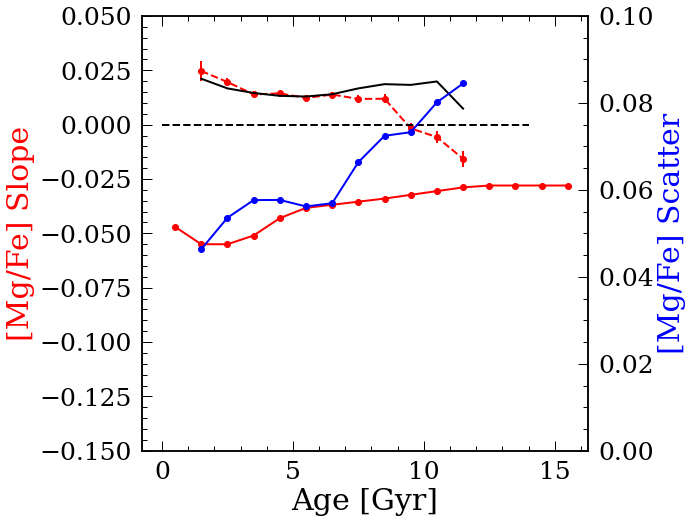

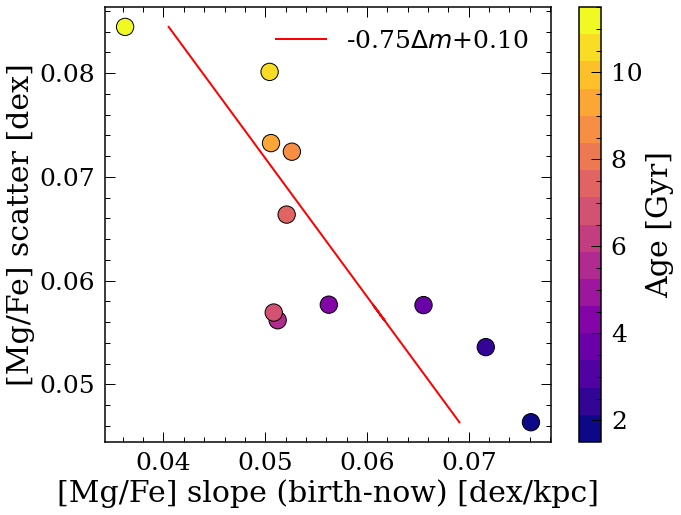

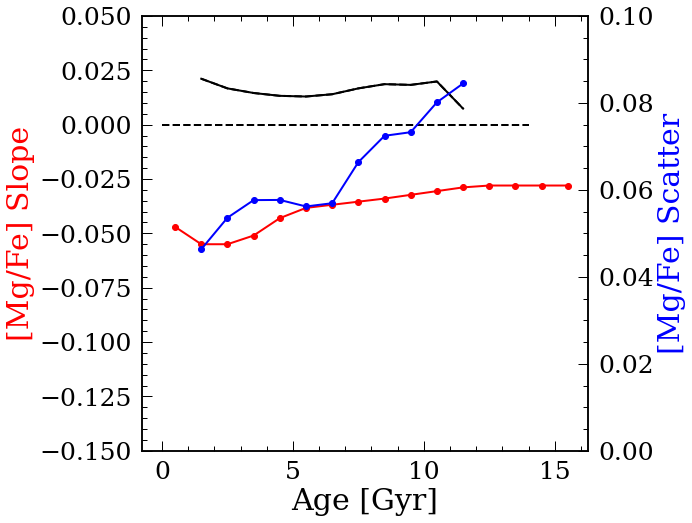

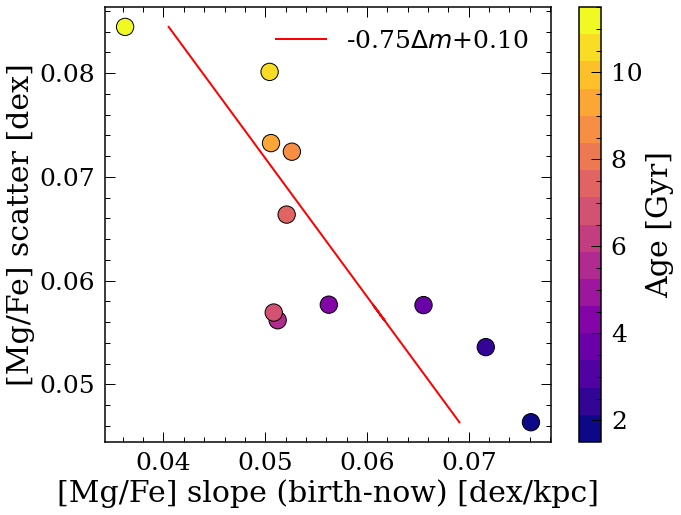

In [38]:
agebincalc = np.linspace(0,16,17)
xrange = [8.5,9.5]

sub_check = sub_rbir.loc[abs(sub_rbir['Z'])<1]
sub_check = sub_check.loc[(sub_check['AGE_ERR']<np.diff(agebincalc)[0])]
#sub_check = sub_check.loc[(sub_check['AGE']>1.5)].reset_index(drop=True)
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)



ages_afe, slopesafe_rbir, fehscatterafe_rbir = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)



from scipy.interpolate import interp1d
agefit = 15

#df = pd.read_csv('Xiang_selslope_afe.csv')
df = pd.read_csv('Xiang_selslope_afe_rg.csv')
ages_afe, slopes_afe, fehscatter_afe = df['age'].values,df['slopes'].values,df['fehscatter'].values
slopesafe_err, fehscatterafe_err = df['slopes_err'], df['fehscatter_err']

plt.figure(figsize=(8,8))
plt.errorbar(ages_afe, slopes_afe, yerr=slopesafe_err, fmt='r--o')

age_and = [0.5, 1.5, 3, 5, 8.5, 12, 16]
slopes_and = [-0.047, -0.055, -0.055, -0.039, -0.034, -0.028, -0.028]

slopes_fit = interp1d(age_and, slopes_and)
slopes_afe = slopes_fit(ages_afe)
slopes_err = np.zeros(len(ages_afe))

plt.errorbar(ages_afe, slopes_afe, fmt='r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Mg/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe, fehscatter_afe, fmt='b-o')
plt.ylim([0.,0.1])
plt.ylabel('[Mg/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir, fehscatterafe_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (df_afe['age']<20)

plt.figure(figsize=(10,8))
plt.scatter(df_afe['slopes_rbir']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slopes_rbir']-df_afe['slopes'])[m2])
plt.xlabel('[Mg/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[Mg/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))


slope_rbir_infer = np.zeros(len(df_afe))
slope_rbir_infer[~m2] = p((df_afe['fehscatter'][~m2]))+df_afe['slopes'][~m2]
slope_rbir_infer[m2] = df_afe['slopes_rbir'][m2]

df_afe['slope_rbir_infer'] = slope_rbir_infer

#print(df)

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()





plt.figure(figsize=(8,8))
plt.plot(ages_afe, slopes_afe, 'r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.plot(df_afe['age'], df_afe['slope_rbir_infer'], 'k--',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[Mg/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
plt.plot(ages_afe, fehscatter_afe, 'b-o')
plt.ylim([0.,0.1])
plt.ylabel('[Mg/Fe] Scatter', color='b',zorder=5)




plt.figure(figsize=(10,8))
plt.scatter(df_afe['slope_rbir_infer']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
m2 = (df_afe['age']<agefit)

p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slope_rbir_infer']-df_afe['slopes'])[m2])

plt.xlabel('[Mg/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[Mg/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

#df['slope_rbir_infer'] = p((df['fehscatter']))+df['slopes']

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()


# Plot new Rbir

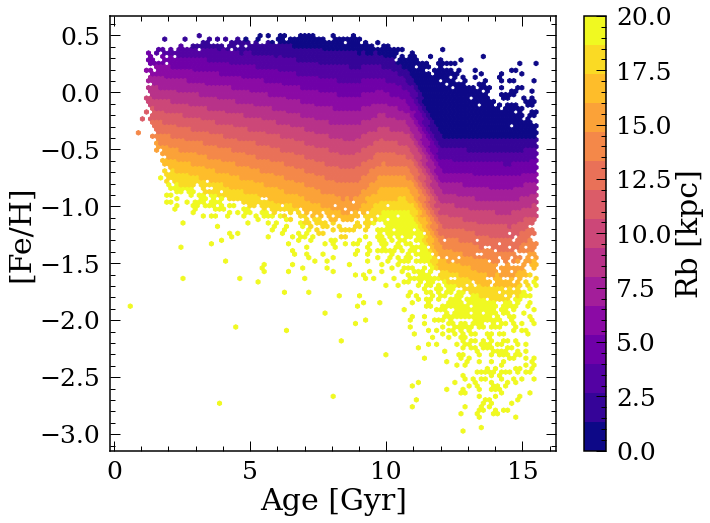

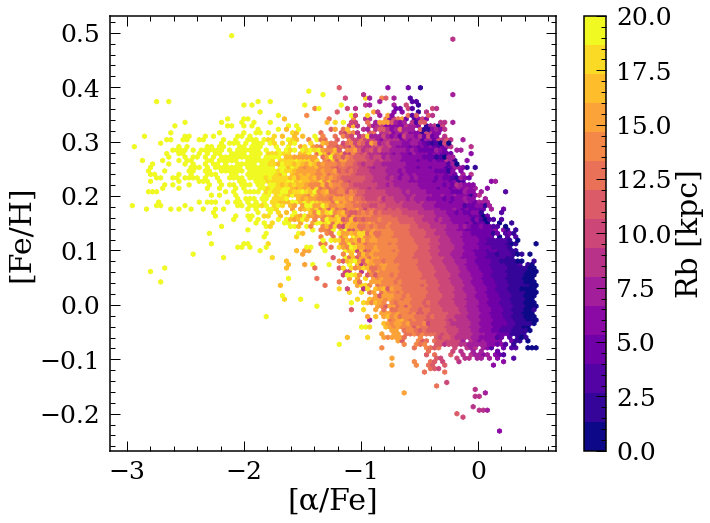

In [56]:
sub_tryRb = sub_rbir

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], C=sub_tryRb['Rb'], 
          vmin=0, vmax=20, cmap=plt.get_cmap('plasma',15))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], C=sub_tryRb['Rb'], 
          vmin=0, vmax=20, cmap=plt.get_cmap('plasma',15))
plt.xlabel('[α/Fe]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')



0.008054069276260208


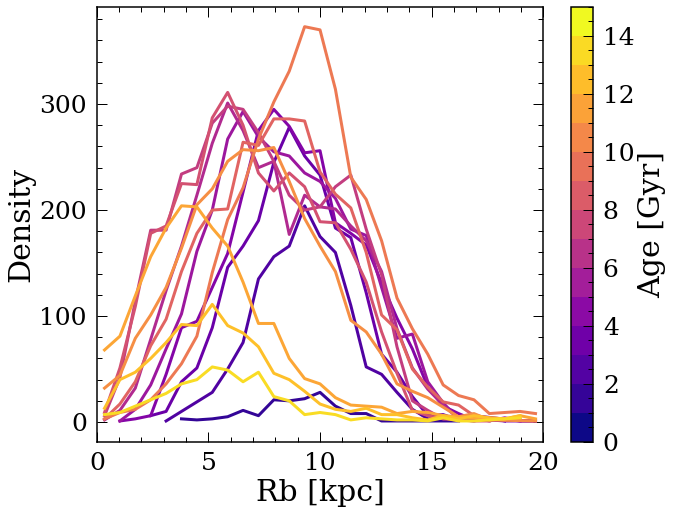

In [57]:
m2 = (abs(sub_tryRb['R']-8.2)<0.2)

sub_tryRb_sn = sub_tryRb[m2].reset_index(drop=True)
agebin_Rb = np.linspace(0,15,16)
agebin_colors = getcolor(agebin_Rb)
plt.figure(figsize=(10,8))
#plt.hist(sub_tryRb['Rb'], color='k', alpha=0.2, bins=np.linspace(0,20,100))
for i in range(len(agebin_Rb)-1):
    
    sub_sing = sub_tryRb_sn.loc[(sub_tryRb_sn['AGE']>agebin_Rb[i])&(sub_tryRb_sn['AGE']<agebin_Rb[i+1])]
    fre, edg = np.histogram(sub_sing['Rb'], bins=np.linspace(0,20,30), density=False)
    
    m = (fre!=0)
    plt.plot((edg[1:]+edg[:-1])[m]/2, fre[m], color=agebin_colors[i], linewidth=3)
    
    """plt.vlines(np.mean(sub_sing['Rb_new']), ymin=0, ymax=800, color=agebin_colors[i],
              linewidth=3)"""
#plt.vlines(8.2, ymin=0, ymax=900, color='k')
plt.scatter(100,0,c=5,vmin=min(agebin_Rb),vmax=max(agebin_Rb),
           cmap=plt.get_cmap('plasma', len(agebin_Rb)-1))
plt.xlim([0,20])
plt.xlabel('Rb [kpc]')
plt.ylabel('Density')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')

print(sum(sub_tryRb['Rb']<0)/len(sub_tryRb['Rb']))


In [41]:

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr( sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))

ages, rs, avrs_phi = avr(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))

ages, rs, avrs_r = avr(sub_tryRb['Rb'].values, sub_tryRb['AGE'].values,
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,12,7), agebin=np.linspace(2,20,15))


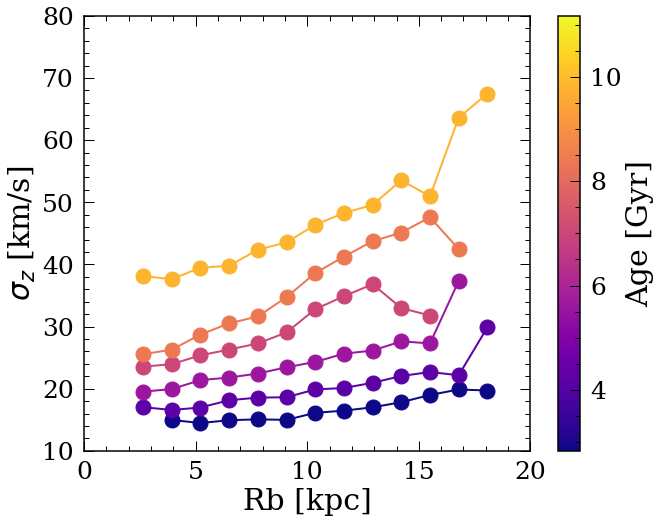

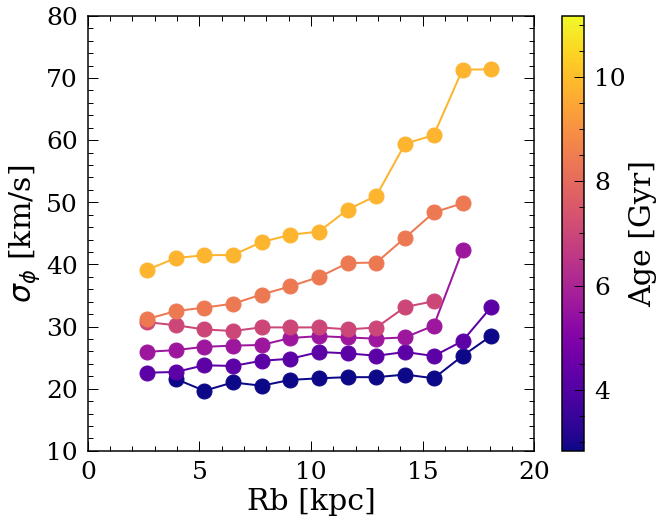

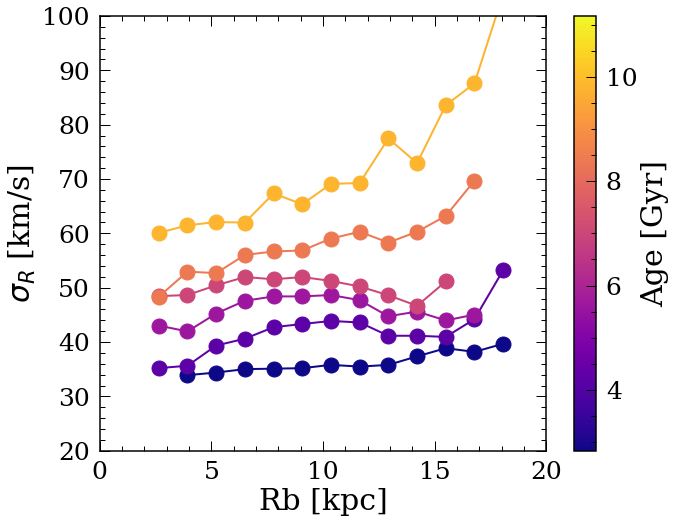

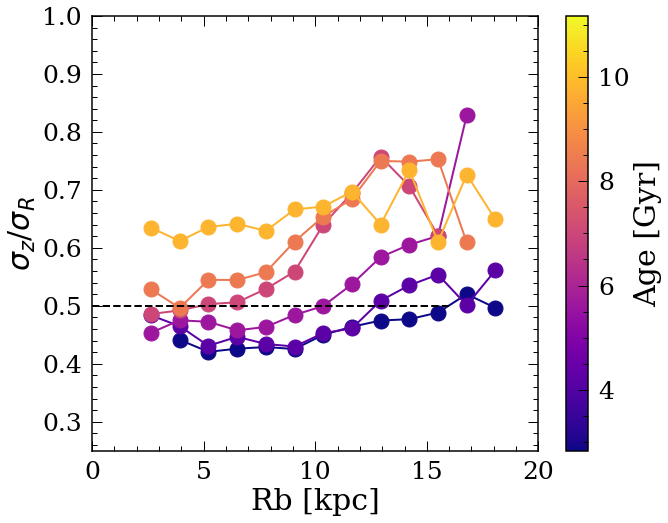

In [42]:

colors = getcolor(np.linspace(2,12,7))

plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$ [km/s]')
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
plt.ylim([10, 80])
plt.xlim([0,20])
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 80])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()



plt.figure(figsize=(10,8))
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Age = %.2f Gyr'%rs[i],
            markersize=15)
    plt.xlabel('Rb [kpc]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.ylim([0.25, 1])
plt.xlim([0,20])
plt.scatter(-100, -100, c=1, vmin=min(rs), vmax=max(rs), cmap='plasma')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
#plt.legend()

plt.plot([0,16], [0.5,0.5], 'k--')




In [60]:
#sub['Rmean'] = (sub['R_PERI']+sub['R_APO'])/2

sub_tryRb = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
ages, rs, avrs_z = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                       sub_tryRb['VZ'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_phi = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                         sub_tryRb['VT'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

ages, rs, avrs_r = avr(sub_tryRb['AGE'].values, sub_tryRb['Rb'].values, 
                       sub_tryRb['VR'].values, 
                     rbin=np.linspace(2,15,5), agebin=np.linspace(0,12,13))

np.array()

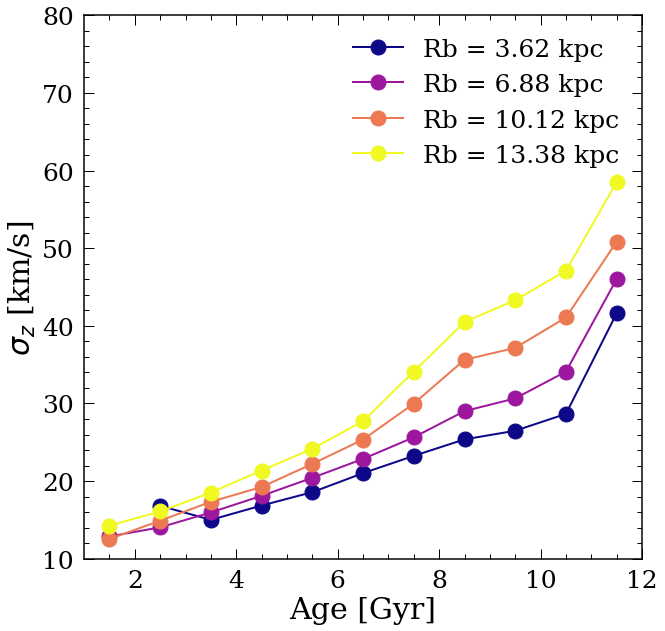

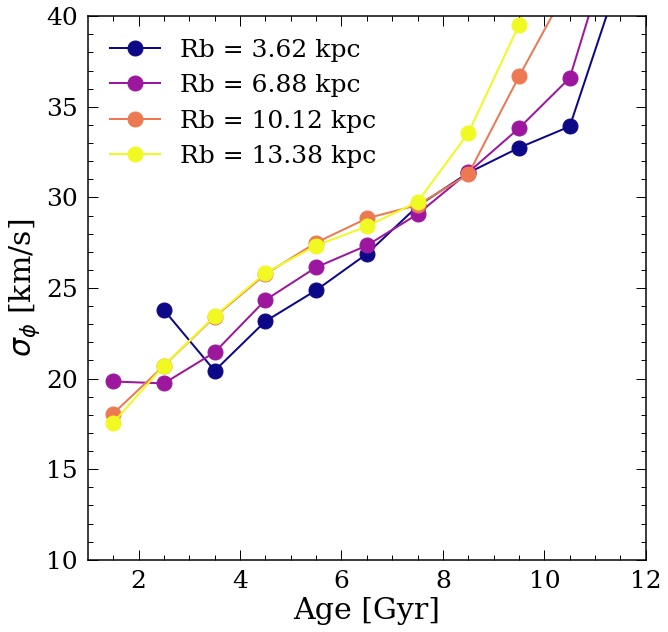

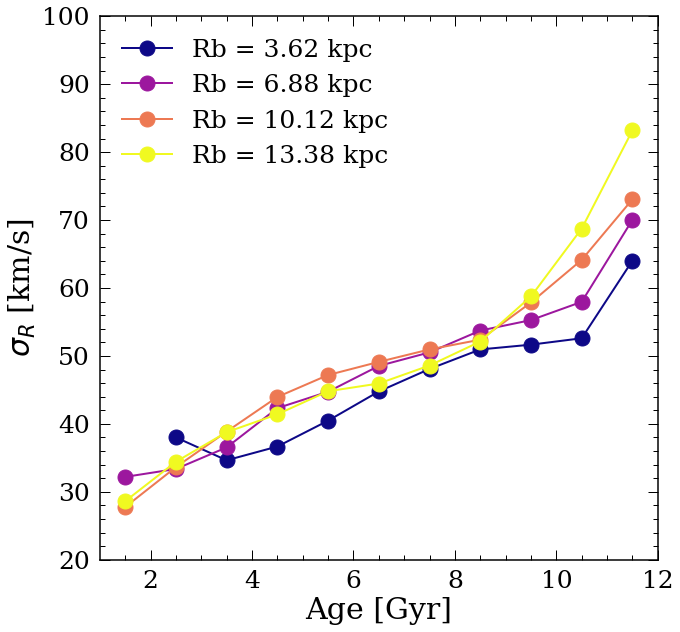

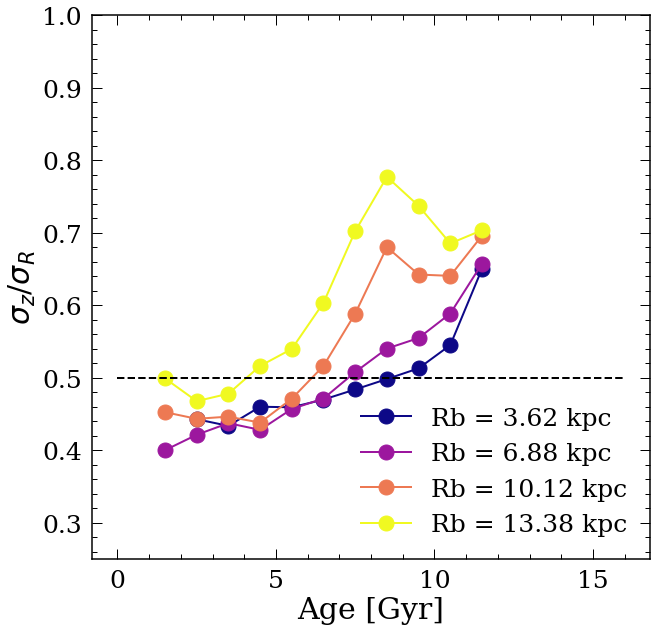

In [44]:

colors = getcolor(rs)

plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$ [km/s]')
plt.ylim([10, 80])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_phi[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_ϕ$ [km/s]')
plt.ylim([10, 40])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_R$ [km/s]')
plt.ylim([20, 100])
plt.legend()



plt.figure()
for i in range(len(rs)):
    plt.plot(ages, avrs_z[i,:]/avrs_r[i,:], 'o-', color=colors[i], label='Rb = %.2f kpc'%rs[i],
            markersize=15)
    plt.xlabel('Age [Gyr]')
    plt.ylabel('$σ_z$/$σ_R$')
plt.legend()
plt.ylim([0.25, 1])

plt.plot([0,16], [0.5,0.5], 'k--')







In [45]:
def getmigration(r, rbir, age, agebin=np.linspace(0,14,8),
             rbin=10, xlims=[6,12],ylims=[-1.5,0.5]):
    rbins = np.linspace(xlims[0], xlims[1], rbin)
    scatters = np.zeros((len(agebin)-1, rbin-1))
    
    m = (r>xlims[0])&(r<xlims[1])
    r, rbir, age = r[m], rbir[m], age[m]
    
    for i in range(len(agebin)-1):
        m = (age>agebin[i])&(age<agebin[i+1])
        r_sing, rbir_sing = r[m], rbir[m]

        for j in range(rbin-1):
            m = (r_sing>rbins[j])&(r_sing<rbins[j+1])
            if sum(m)<10:
                scatters[i,j] = np.nan
            else:
                r_sing_2, rbir_sing_2 = r_sing[m], rbir_sing[m]
                scatters[i,j] = np.std(rbir_sing_2-r_sing_2)

                
    return (agebin[:-1]+agebin[1:])/2, (rbins[:-1]+rbins[1:])/2, scatters




(0.0, 7.0)

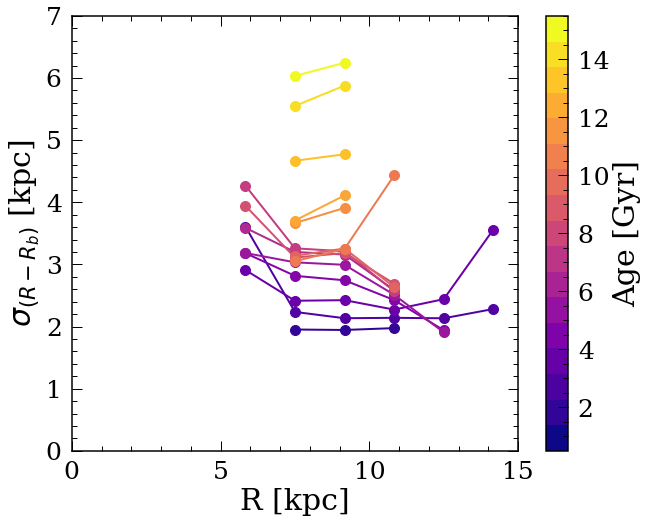

In [46]:
#agebincalc = np.linspace(0,14,10)
m = (abs(sub_tryRb['Z'])<0.5)
m = (abs(sub_tryRb['Z'])<1)&(sub_tryRb['AGE_ERR']<np.diff(agebincalc)[0])
m = m&(sub_tryRb['AGE']>1.5)

ages, rs, sigmaR = getmigration(sub_tryRb['R'].values[m], 
                                        sub_tryRb['Rb'].values[m], 
                                        sub_tryRb['AGE'].values[m],
                                        agebin=agebincalc,
                                        xlims=[0,15],rbin=10)



colors = getcolor(ages)
plt.figure(figsize=(10,8))
for i in range(len(ages)):
    plt.plot(rs, sigmaR[i,:], '-o', color=colors[i], markersize=10)
plt.scatter(-10,-10,c=0, vmin=min(ages), vmax=max(ages),
            cmap=plt.get_cmap('plasma',len(agebincalc)))
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.xlabel('R [kpc]')
plt.ylabel('$σ_{(R-R_b)}$ [kpc]')
plt.xlim([0,15])
plt.ylim([0,7])






In [47]:
def movingMed_time(x,y,x_window,delta_x_window):
    # medians output
    x_med=np.zeros(len(x))
    y_med=np.zeros(len(y))

    # define the boundaries of the windows
    if len(x)==0:
        return x_med,y_med
    window_min=float(min(x))
    window_max=float(window_min+delta_x_window)
    
    # max time
    maxtime=max(x)
    
    # break when time window hits the end
    while window_max<=maxtime+x_window:
        seldf=(x>=window_min) & (x<=window_max) # get points between the window
        if sum(seldf)<10:
            x_med[seldf]=np.nan
            y_med[seldf]=np.nan
        else:
            x_med[seldf]=np.median(x[seldf]) # all values for these indices are subsituded with median time
            y_med[seldf]=np.median(y[seldf]) # all values for these indices are subsituded with median flux

        # slide the window
        window_min=window_min+delta_x_window
        window_max=window_max+delta_x_window
    return x_med, y_med

"plt.figure(figsize=(10,8))\nplt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',\n          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)\nfor i in range(len(Rbbin)-1):\n\n    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])\n\n    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]\n    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))\n    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)\n    \n    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,\n                                     0.04,0.04)\n    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)\n    plt.xlim([-1.3,0.6])\n    plt.ylim([-0.2,0.4])\n    #print(sum(m))\n    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)\nplt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), \n            cmap=plt.get_cmap('plasma', len(Rbbin)-1))\nplt.xlabel('[Fe/H]')\nplt

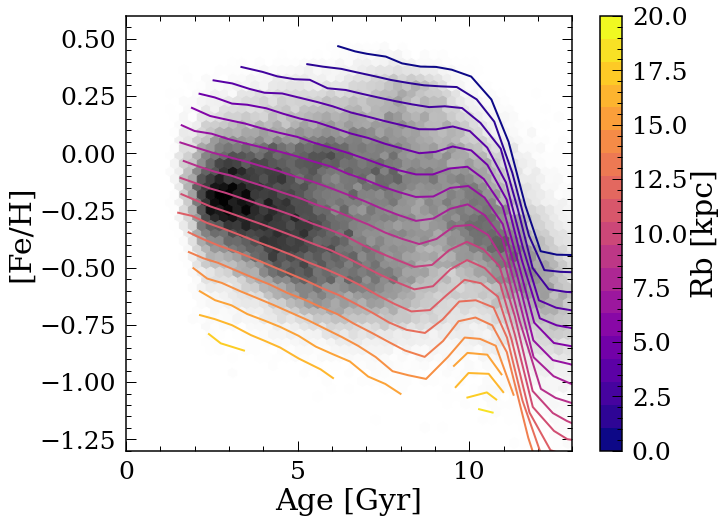

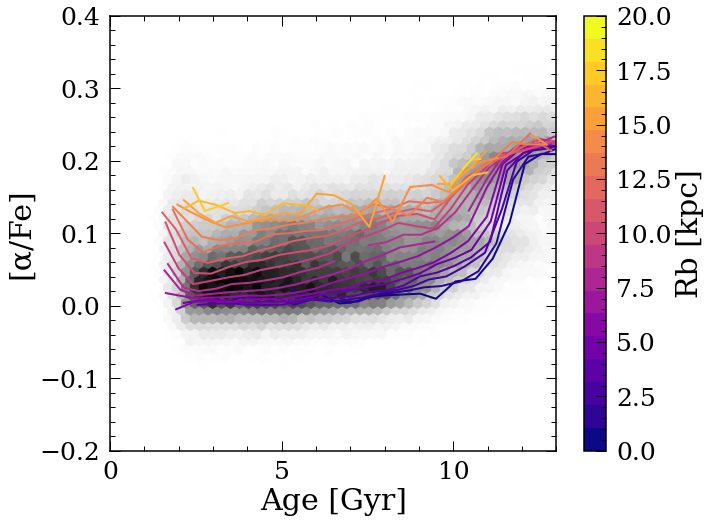

In [48]:
Rbbin = np.linspace(0,20,20)
color_amr = getcolor(range(len(Rbbin)))

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['FEH'], cmap='binary',
          extent=(0,13,-1.3,0.6), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb']>Rbbin[i])&(sub_tryRb['Rb']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-1.3,0.6])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')
    

plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['AGE'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(0,13,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb']>Rbbin[i])&(sub_tryRb['Rb']<Rbbin[i+1])
    """plt.hexbin(sub['AGE'][m], sub['FEH'][m], extent=(0,18,-2.5,0.5), cmap='jet',
            mincnt=1, gridsize=50)"""
    age_amr_all, feh_amr_all = sub_tryRb['AGE'].values[m], sub_tryRb['ALPHA_FE'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     1,0.5)
    plt.plot(age_amr, feh_amr, '-', color=color_amr[i], linewidth=2)
    plt.xlim([0,13])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')


"""plt.figure(figsize=(10,8))
plt.hexbin(sub_tryRb['FEH'], sub_tryRb['ALPHA_FE'], cmap='binary',
          extent=(-1.3,0.6,-0.2,0.4), gridsize=50, mincnt=1)
for i in range(len(Rbbin)-1):

    m = (sub_tryRb['Rb_new']>Rbbin[i])&(sub_tryRb['Rb_new']<Rbbin[i+1])

    age_amr_all, feh_amr_all = sub_tryRb['ALPHA_FE'].values[m], sub_tryRb['FEH'].values[m]
    age_amr_all, feh_amr_all = zip(*sorted(zip(age_amr_all, feh_amr_all)))
    age_amr_all, feh_amr_all = np.array(age_amr_all), np.array(feh_amr_all)
    
    age_amr, feh_amr = movingMed_time(age_amr_all, feh_amr_all,
                                     0.04,0.04)
    plt.plot(feh_amr, age_amr, '-o', color=color_amr[i], linewidth=2)
    plt.xlim([-1.3,0.6])
    plt.ylim([-0.2,0.4])
    #print(sum(m))
    #plt.title('%.2f kpc < Rb < %.2f kpc'%(Rbbin[i], Rbbin[i+1]), fontsize=25)
plt.scatter(-100,-100, c=0, vmin=min(Rbbin), vmax=max(Rbbin), 
            cmap=plt.get_cmap('plasma', len(Rbbin)-1))
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Rb [kpc]')"""
    
    



###  [$\alpha$/Fe] evolution for |R-8.2|<0.5

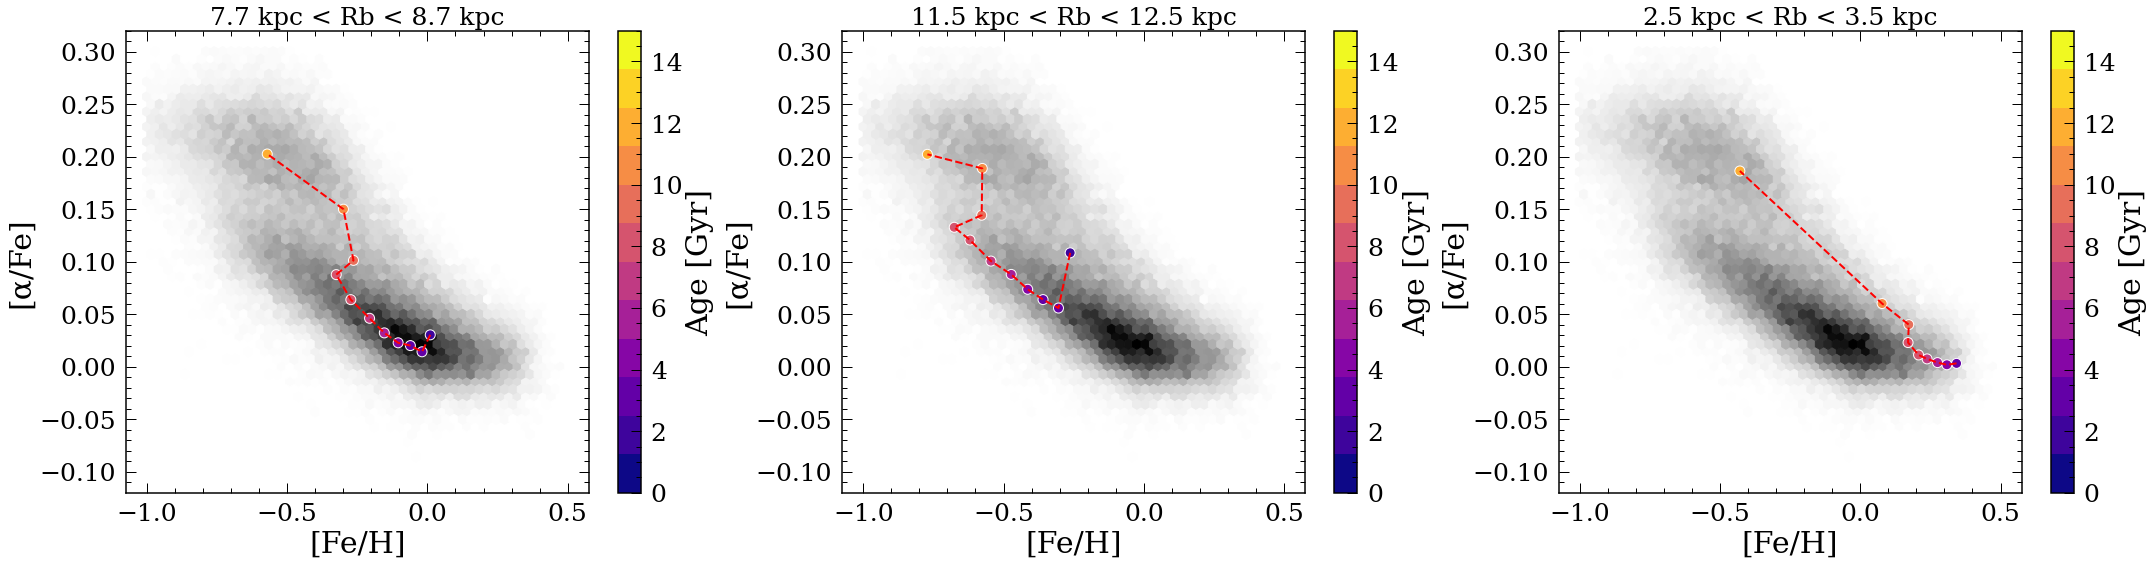

In [49]:
# without correction
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_rbir.loc[abs(sub_rbir['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb < 3.5 kpc', fontsize=25)
plt.tight_layout()

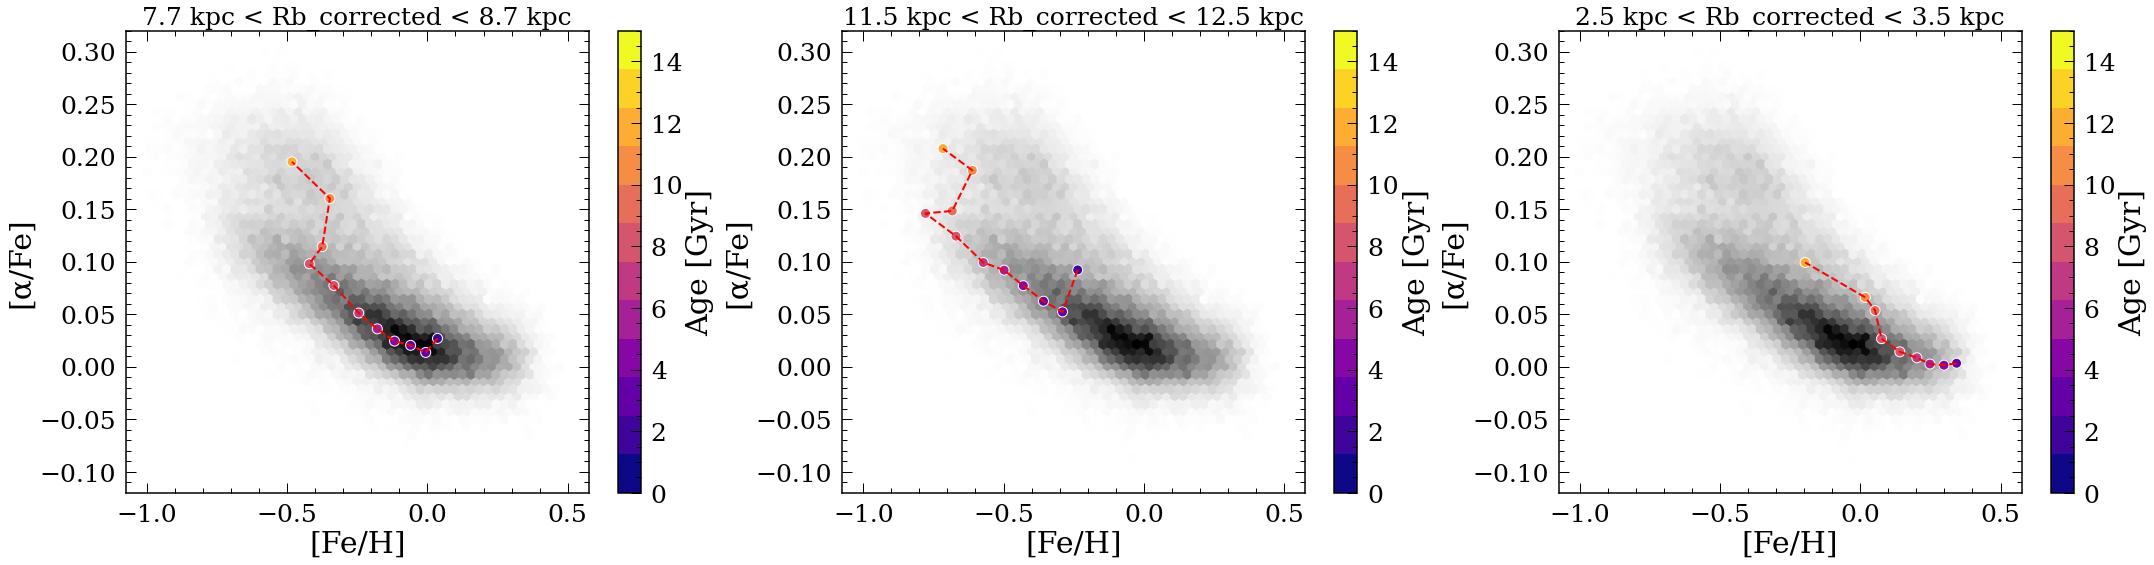

In [347]:
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-8.2)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb_new']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

###  [$\alpha$/Fe] evolution for |R-10|<0.5

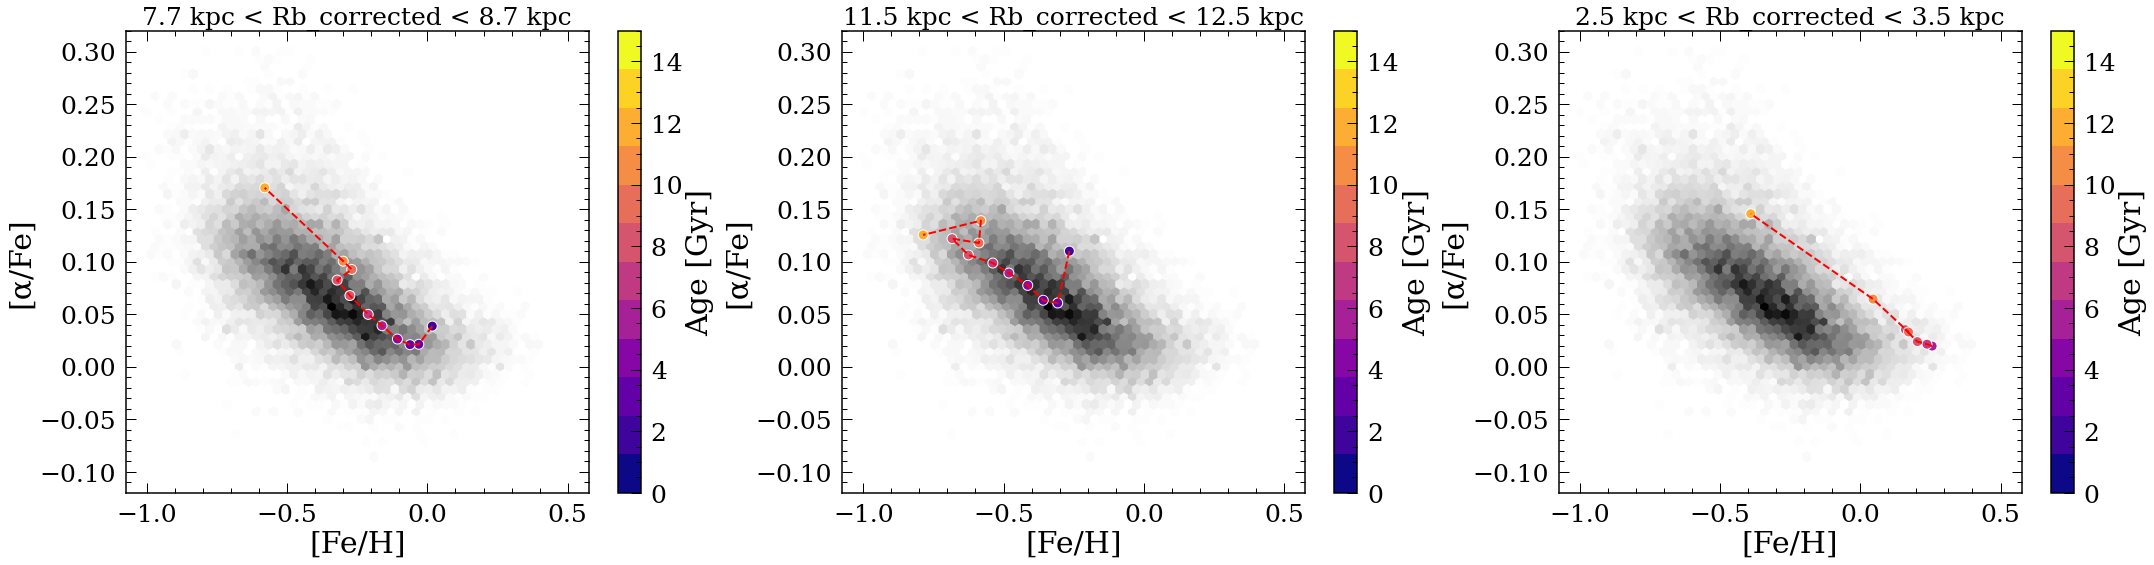

In [50]:
agebin = np.linspace(0,12,13)

meanfeh = np.zeros(len(agebin)-1)
meanafe = np.zeros(len(agebin)-1)

sub_tryRb_sn = sub_tryRb.loc[abs(sub_tryRb['R']-10)<0.5].reset_index(drop=True)

plt.figure(figsize=(30,8))
plt.subplot(1,3,1)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-8.2)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('7.7 kpc < Rb_corrected < 8.7 kpc', fontsize=25)



plt.subplot(1,3,2)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-12)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('11.5 kpc < Rb_corrected < 12.5 kpc', fontsize=25)



plt.subplot(1,3,3)
plt.hexbin(sub_tryRb_sn['FEH'], sub_tryRb_sn['ALPHA_FE'], cmap='binary',
          extent=(-1,0.5,-0.1,0.3), gridsize=50, mincnt=1)

for i in range(len(agebin)-1):

    m = (sub_tryRb_sn['AGE']>agebin[i])&(sub_tryRb_sn['AGE']<agebin[i+1])
    m = m&(abs(sub_tryRb_sn['Rb']-3)<0.5)
    if sum(m)<10:
        meanfeh[i] = np.nan
        meanafe[i] = np.nan
    else:
        meanfeh[i] = np.median(pd.Series(sub_tryRb_sn['FEH'].values[m]).dropna())
        meanafe[i] = np.median(pd.Series(sub_tryRb_sn['ALPHA_FE'].values[m]).dropna())

plt.plot(meanfeh, meanafe, 'r--')
plt.scatter(meanfeh, meanafe, c = (agebin[1:]+agebin[:-1])/2,
           vmin=0, vmax=15, cmap=plt.get_cmap('plasma', len(meanfeh)), 
            s=100, edgecolor='w')
plt.xlabel('[Fe/H]')
plt.ylabel('[α/Fe]')
cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.title('2.5 kpc < Rb_corrected < 3.5 kpc', fontsize=25)
plt.tight_layout()

### check [α/Fe] scatter after correction

all stars 168074
with [Mg/Fe] 143252


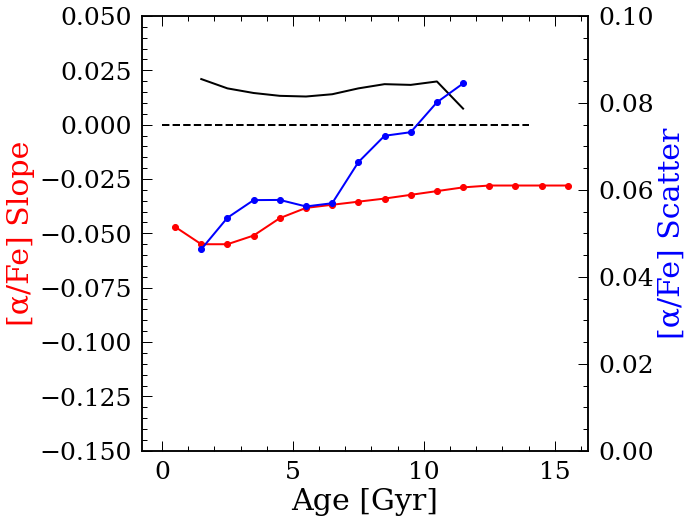

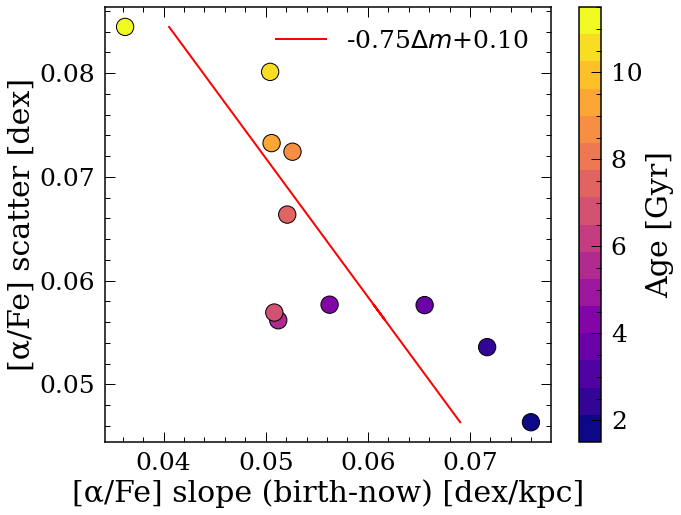

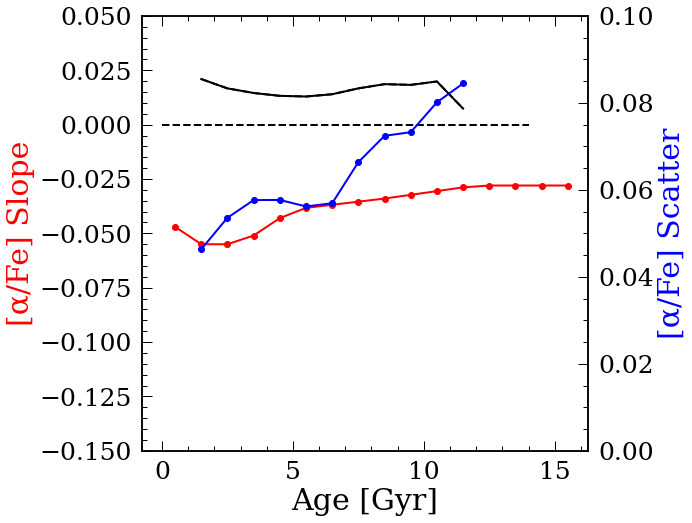

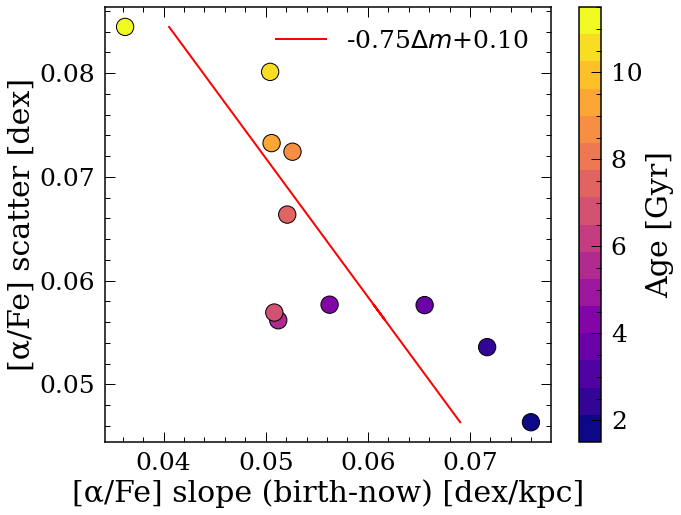

In [51]:

sub_check = sub_tryRb.loc[abs(sub_tryRb['Z'])<1].reset_index(drop=True)
sub_check = sub_check.loc[(sub_check['AGE_ERR']<np.diff(agebincalc)[0])]
sub_check = sub_check.loc[(sub_check['AGE']>1.5)].reset_index(drop=True)

#sub_check = sub_check.dropna(subset=['ALPHA_FE','ALPHA_FE_ERR'])
print('all stars', len(sub_check))
sub_check = pd.merge(sub_check, 
                     pd.read_csv('Xiang_elements.csv')[['MG_FE','MG_FE_ERR','SPECID']],
                    left_on='SPECID', right_on='SPECID',how='inner')
sub_check = sub_check.loc[abs(sub_check['MG_FE'])<100].dropna(subset=['MG_FE','MG_FE_ERR']).reset_index(drop=True)
print('with [Mg/Fe]', len(sub_check))

ages_afe, slopesafe_rbir, fehscatterafe_rbir = monoage_line(sub_check['MG_FE'].values, 
                                        sub_check['Rb'].values, 
                                        sub_check['AGE'].values,
                                        agebin=agebincalc,
                                        xlims=[0,15],
                                       feherr=sub_check['MG_FE_ERR'].values,
                                       plotlegend=False,pltfig=False)


agefit = 15

#df = pd.read_csv('Xiang_selslope_afe.csv')
df = pd.read_csv('Xiang_selslope_afe_rg.csv')
ages_afe, slopes_afe, fehscatter_afe = df['age'].values,df['slopes'].values,df['fehscatter'].values
slopesafe_err, fehscatterafe_err = df['slopes_err'], df['fehscatter_err']



age_and = [0.5, 1.5, 3, 5, 8.5, 12, 16]
slopes_and = [-0.047, -0.055, -0.055, -0.039, -0.034, -0.028, -0.028]

slopes_fit = interp1d(age_and, slopes_and)
slopes_afe = slopes_fit(ages_afe)
slopes_err = np.zeros(len(ages_afe))

offsetfac = 0.0
plt.figure(figsize=(8,8))
#plt.errorbar(ages_afe, slopes_afe, yerr=slopes_err, fmt='r-o')
plt.errorbar(ages_afe, slopes_afe, fmt='r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
#plt.errorbar(ages_afe, fehscatter_afe, yerr=fehscatterafe_err, fmt='b-o')
plt.errorbar(ages_afe, fehscatter_afe, fmt='b-o')
plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)


df_afe = pd.DataFrame(np.array((ages_afe, slopes_afe, fehscatter_afe, slopesafe_rbir, fehscatterafe_rbir)).T,
            columns=['age', 'slopes', 'fehscatter', 'slopes_rbir', 
                     'fehscatter_rbir'])


df_afe = df_afe.dropna(subset=['slopes','fehscatter']).reset_index(drop=True)

df_afe['slopes_rbir'] = df_afe['slopes_rbir']
m2 = (df_afe['age']<12)

plt.figure(figsize=(10,8))
plt.scatter(df_afe['slopes_rbir']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slopes_rbir']-df_afe['slopes'])[m2])
plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

slope_rbir_infer = np.zeros(len(df_afe))
slope_rbir_infer[~m2] = p((df_afe['fehscatter'][~m2]))+df_afe['slopes'][~m2]
slope_rbir_infer[m2] = df_afe['slopes_rbir'][m2]

df_afe['slope_rbir_infer'] = slope_rbir_infer

#print(df)

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()





plt.figure(figsize=(8,8))
plt.plot(ages_afe, slopes_afe, 'r-o')
plt.plot(ages_afe, slopesafe_rbir, 'k-',zorder=5)
plt.plot(df_afe['age'], df_afe['slope_rbir_infer'], 'k--',zorder=5)
plt.xlabel('Age [Gyr]')
plt.ylabel('[α/Fe] Slope', color='r',zorder=5)
plt.plot([0,14],[0,0], 'k--',zorder=5)
plt.ylim([-0.15, 0.05])

plt.twinx()
plt.plot(ages_afe, fehscatter_afe, 'b-o')
plt.ylim([0.,0.1])
plt.ylabel('[α/Fe] Scatter', color='b',zorder=5)




plt.figure(figsize=(10,8))
plt.scatter(df_afe['slope_rbir_infer']-df_afe['slopes'], df_afe['fehscatter'], 
           c=df_afe['age'], s=300, edgecolor='k', 
            cmap=plt.get_cmap('plasma', len(df)))
m2 = (df_afe['age']<agefit)

p = fitpoints(df_afe['fehscatter'][m2], (df_afe['slope_rbir_infer']-df_afe['slopes'])[m2])

plt.xlabel('[α/Fe] slope (birth-now) [dex/kpc]')
plt.ylabel('[α/Fe] scatter [dex]')
plt.plot(p((df_afe['fehscatter']))[m2],
         (df_afe['fehscatter'])[m2], 'r-', 
         label="%.2f$Δm$+%.2f"%(p[1],p[0]))

#df['slope_rbir_infer'] = p((df['fehscatter']))+df['slopes']

cb = plt.colorbar()
cb.set_label('Age [Gyr]')
plt.legend()



In [58]:
from astropy import units as u
from astropy import uncertainty as unc

sub_tryRb['R_err'] = (sub_tryRb['PARALLAX'])**-2*(sub_tryRb['PARALLAX_ERROR'])


agebincalc_rm = np.linspace(0,14,15)
mean_dr = np.zeros(len(agebincalc_rm)-1)
mean_dr_err = np.zeros(len(agebincalc_rm)-1)

sub_tryRb['AGE_sca'] = sub_tryRb['AGE']/16*14
sub_tryRb = sub_tryRb.loc[sub_tryRb['AGE_ERR']<np.diff(agebincalc_rm)[0]]

for i in trange(len(agebincalc_rm)-1):
    sub_tryRb_sing = sub_tryRb.loc[(sub_tryRb['AGE_sca']>agebincalc_rm[i])&(sub_tryRb['AGE_sca']<agebincalc_rm[i+1])]
    #mean_dr[i] = np.std(sub_tryRb_sing['Rb_new']-sub_tryRb_sing['R'])    
    #mean_dr_err[i] = mean_dr[i]/(len(sub_tryRb_sing)-1)
    
    sub_tryRb_sing = sub_tryRb_sing.dropna(subset=['Rb','R_err','R'])
    sub_tryRb_sing = sub_tryRb_sing.loc[sub_tryRb_sing['R_err']<1]
    
    if len(sub_tryRb_sing)<30:
        mean_dr[i] = np.nan
        mean_dr_err[i] = np.nan
        continue
    Rbdist = unc.normal(sub_tryRb_sing['Rb'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    Rdist = unc.normal(sub_tryRb_sing['R'].values, 
                     std=sub_tryRb_sing['R_err'].values, 
                     n_samples=1000)
    
    drdist = np.std(Rbdist-Rdist)
    
    mean_dr[i] = drdist.pdf_median()
    mean_dr_err[i] = np.median(np.sqrt(drdist.pdf_var()))

100%|██████████| 14/14 [00:15<00:00,  1.11s/it]


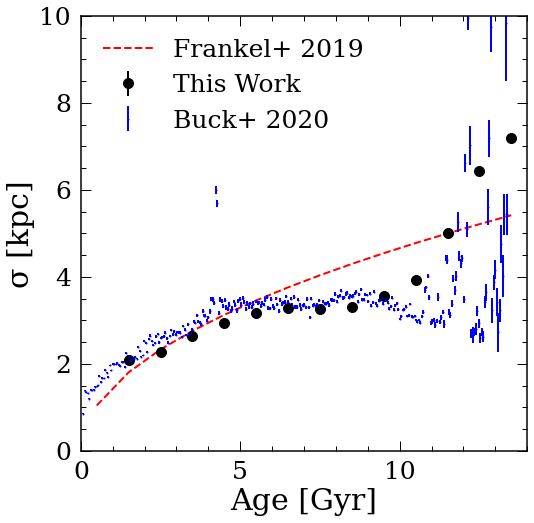

In [59]:
    
plt.figure(figsize=(8,8))
dR_sim = pd.read_pickle('BuckMigration.pkl')

plt.errorbar((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, mean_dr,
             yerr=mean_dr_err, fmt='ko', label='This Work', 
            markersize=10)
plt.plot((agebincalc_rm[1:]+agebincalc_rm[:-1])/2, 
         3.9*np.sqrt((agebincalc_rm[1:]+agebincalc_rm[:-1])/2/7), 
         'r--', label='Frankel+ 2019')

m = (dR_sim['NoS']>30)
plt.errorbar(dR_sim['meanage'][m], dR_sim['meandR'][m],
             yerr=dR_sim['meadR_err'][m], fmt='bo', 
             label='Buck+ 2020', markersize=1)

plt.xlim([0,14])
plt.ylim([0,10])
plt.xlabel('Age [Gyr]')
plt.ylabel('σ [kpc]')
plt.legend()